In [1]:
import os
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from palettable.colorbrewer.sequential import YlGn_8
from palettable.wesanderson import Mendl_4
from palettable.cartocolors.sequential import PurpOr_6
from palettable.colorbrewer.diverging import PuOr_7

from ideotype.data_process import read_data, agg_sims, fetch_sim_values, parse_mature
from ideotype.analysis import identify_top_phenos, rank_all_phenos, rank_top_phenos
from ideotype.figures import plot_sims_raw, plot_sims_phenostage
from ideotype.init_params import params_sample
from ideotype.utils import fold
from ideotype import DATA_PATH

In [2]:
run_name = 'present'

# Read in data etc.
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

# Queried maizsim outputs
df_sims = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_yield.csv'))
df_phys = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_phys.csv'))
df_carbon = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_carbon.csv'))
df_mass = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_mass.csv'))
df_leaves = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_leaves.csv'))
df_waterdeficit = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_waterdeficit_sum = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit_sum.csv'))
df_waterpotential = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterpotential.csv'))
df_phenology = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_pheno.csv'))
start_dates = [int(datetime.strptime(date, '%m/%d/%Y').strftime('%j')) for date in df_phenology.date_start]
df_phenology['jday'] = start_dates
df_gseason_climate = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))

In [3]:
# Fetch raw sim values
phenos_ranked = rank_top_phenos('present',20,1,1)
An_sun = fetch_sim_values(df_phys, '"grainFill"', 'An_sun', phenos_ranked)
An_shade = fetch_sim_values(df_phys, '"grainFill"', 'An_shade', phenos_ranked)
LA = fetch_sim_values(df_leaves, '"grainFill"', 'LA', phenos_ranked)
leaves = fetch_sim_values(df_leaves, '"grainFill"', 'leaves', phenos_ranked)
LAI = fetch_sim_values(df_leaves, '"grainFill"', 'LAI', phenos_ranked)
sun_perct = fetch_sim_values(df_phys, '"grainFill"', 'sun_perct', phenos_ranked)
shade_perct = fetch_sim_values(df_phys, '"grainFill"', 'shade_perct', phenos_ranked)

In [10]:
# fetch emergent properties
phenos_ranked = rank_top_phenos('present', 100, 1, 1)
df_pheno_gf = df_phenology[df_phenology.pheno == '"grainFill"']

# grain-filling length
gf_lengths = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_length = df_sub.mean()['pheno_days']
    gf_lengths.append(gf_length)
    
# grain-filling length
gf_startdates = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_startdate = df_sub.mean()['jday']
    gf_startdates.append(gf_startdate)
    
# leaf areas
LA = fetch_sim_values(df_leaves, '"grainFill"', 'LA', phenos_ranked)

### All parameter values

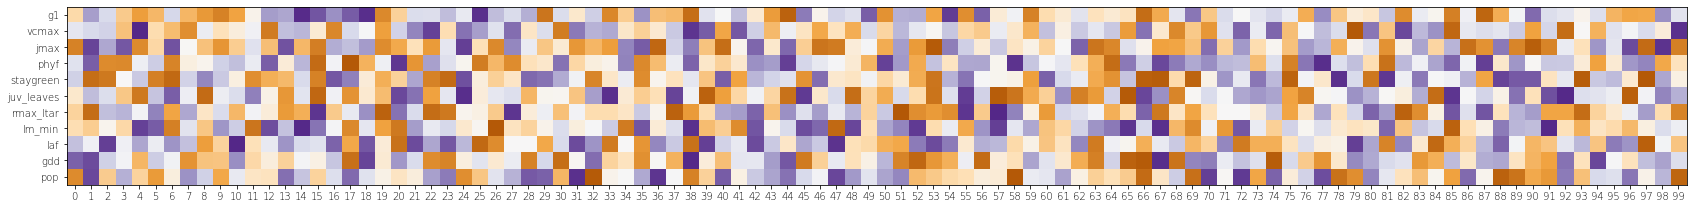

In [4]:
df_params_sub = df_params.iloc[:100,:-1]

problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

for param in params:
    df_params_fold[param] = fold(df_params_sub[param],
                                 param_range[param][0],
                                 param_range[param][1])

# Visualize
fig, ax = plt.subplots(figsize=(30,5))

ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_params_sub.shape[0]))
ax.set_yticks(np.arange(df_params_sub.shape[1]))
ax.set_xticklabels(list(df_params_sub.index),
                   size=10, fontweight='light')
ax.set_yticklabels(list(df_params_sub.columns),
                   size=10, fontweight='light')

fig.subplots_adjust(left=0.15)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_params_all_unranked.png', format='png', dpi=800)

## Parameters to parameters

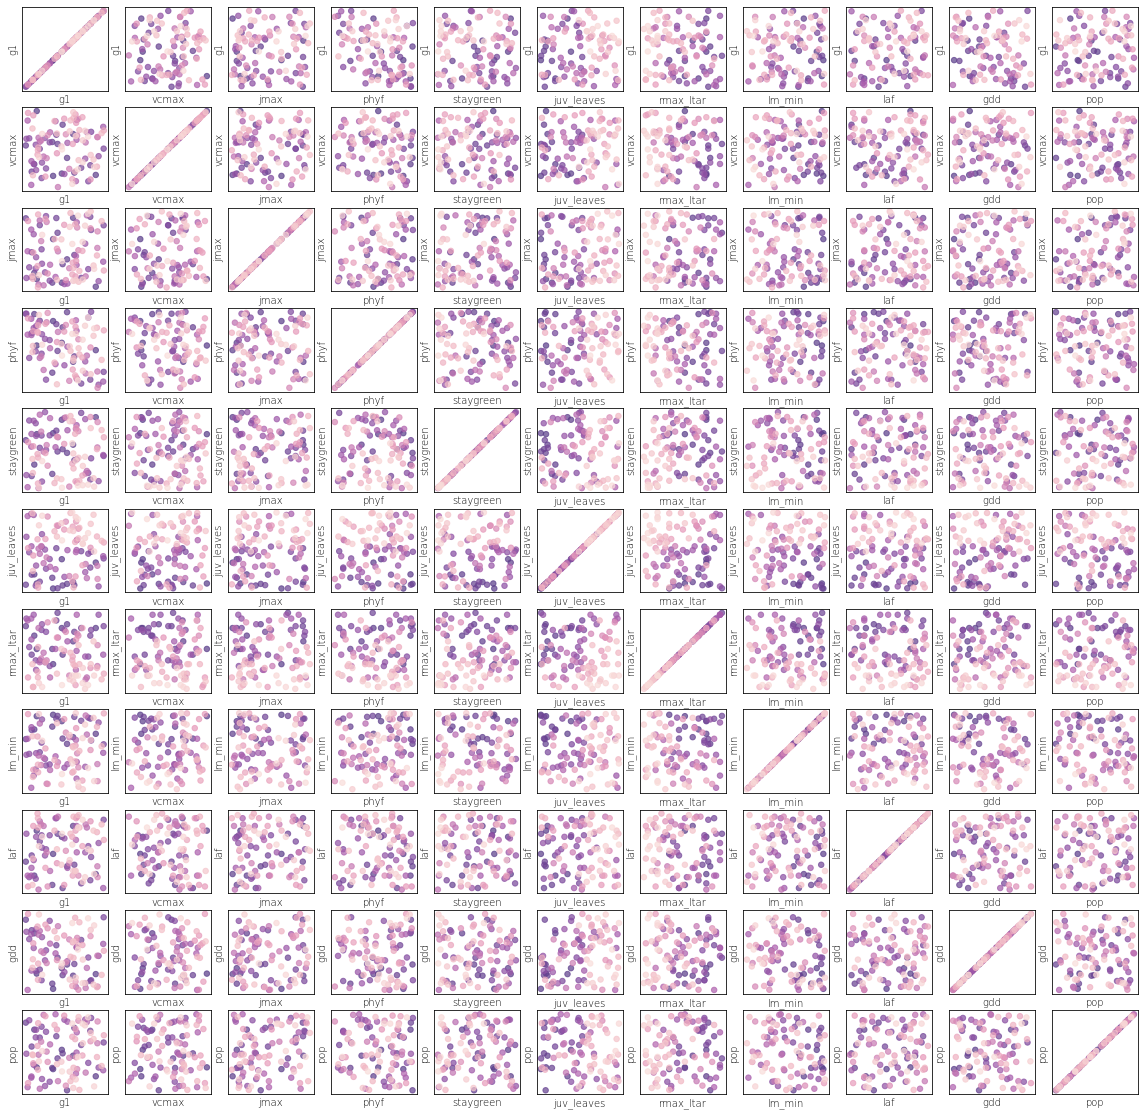

In [7]:
params = df_params.columns[:-1]

fig, axs = plt.subplots(11,11, figsize=(20,20))
for count_x, param_x in enumerate(params):
        
    for count_y, param_y in enumerate(params):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param_x], df_params_sub[param_y], 
                   c=np.arange(100), cmap=PurpOr_6.mpl_colormap.reversed(), 
                   alpha=0.7, s=30)

        ax.set_xlabel(param_x, fontweight='light')
        ax.set_ylabel(param_y, fontweight='light')            
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

fig.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_all.png', format='png', dpi=800)

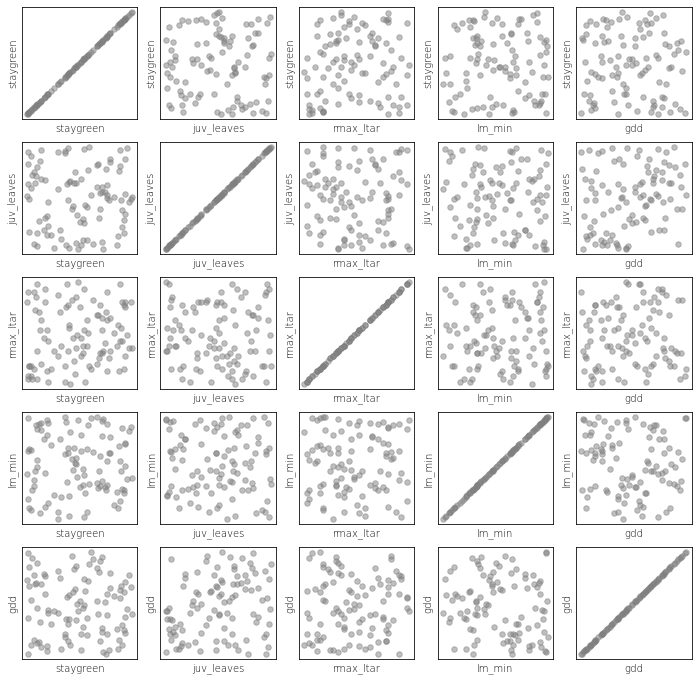

In [17]:
params_sub = ['staygreen', 'juv_leaves', 'rmax_ltar', 'lm_min', 'gdd']

fig, axs = plt.subplots(5,5, figsize=(12,12))
for count_x, param_x in enumerate(params_sub):
        
    for count_y, param_y in enumerate(params_sub):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param_x], df_params_sub[param_y], 
                   c='grey',
                   alpha=0.5, s=30)

        ax.set_xlabel(param_x, fontweight='light')
        ax.set_ylabel(param_y, fontweight='light')
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

fig.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_targeted_greyscale.png', format='png', dpi=800)

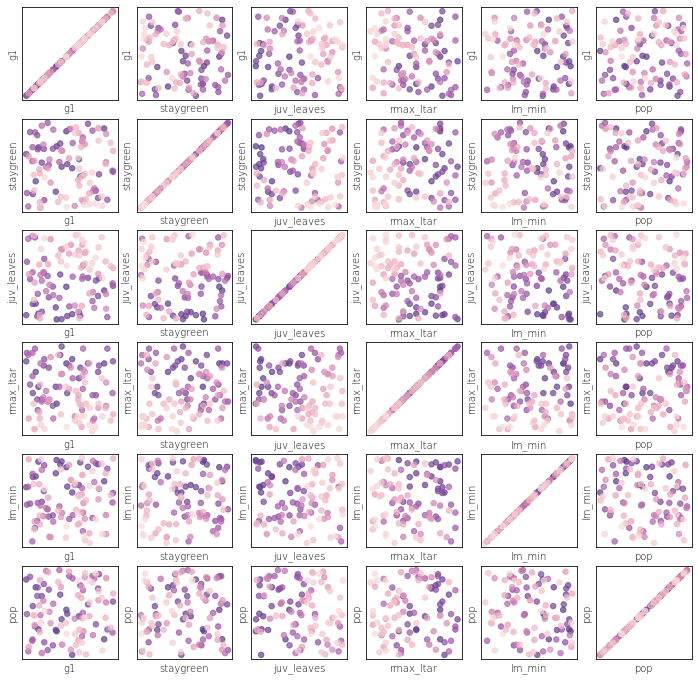

In [139]:
# rank all phenos
phenos_ranked = rank_top_phenos('present', 100, 1, 1)

# put together params info
df_params_s = df_params.iloc[:,:-1][:100]
df_params_sub = df_params_s.iloc[phenos_ranked]

# targeted params
params_sub = ['g1', 'staygreen', 'juv_leaves', 'rmax_ltar', 'lm_min', 'pop']

fig, axs = plt.subplots(6,6, figsize=(12,12))
for count_x, param_x in enumerate(params_sub):
        
    for count_y, param_y in enumerate(params_sub):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param_x], df_params_sub[param_y], 
                   c=np.arange(100), cmap=PurpOr_6.mpl_colormap.reversed(), 
                   alpha=0.7, s=30)

        ax.set_xlabel(param_x, fontweight='light')
        ax.set_ylabel(param_y, fontweight='light')    
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

fig.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_targeted.png', format='png', dpi=800)

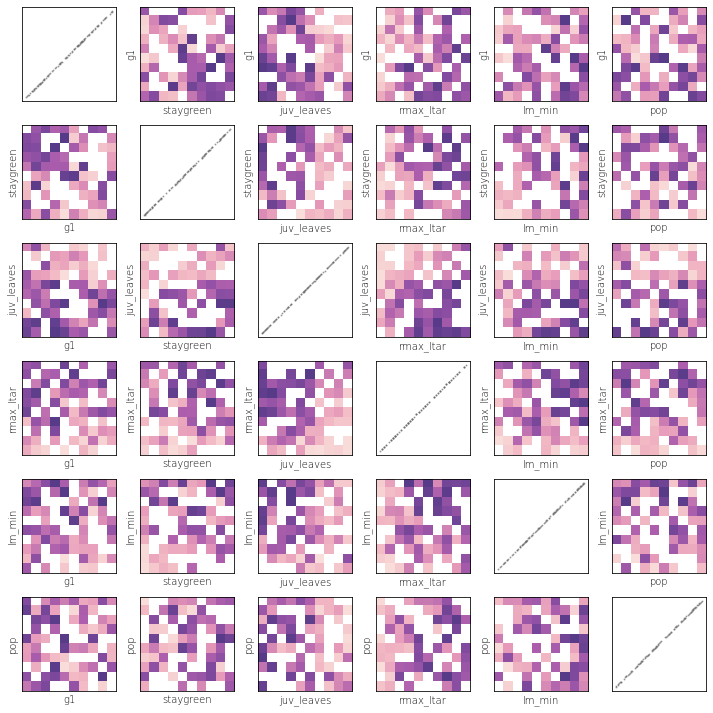

In [8]:
# rank all phenos
phenos_ranked = rank_top_phenos('present', 100, 1, 1)

# put together params info
df_params_s = df_params.iloc[:,:-1][:100]
df_params_sub = df_params_s.iloc[phenos_ranked]

# target phenos
df_params_sub_target = df_params_sub[['g1', 'staygreen', 'juv_leaves', 'rmax_ltar', 'lm_min', 'pop']]
num_params = df_params_sub_target.shape[1]
params = df_params_sub_target.columns
ranks = np.arange(100)

plotting_order = []
for p1 in np.arange(num_params):
    for p2 in np.arange(num_params):
        plotting_order.append((params[p2], params[p1])) # switch to match x-y label

fig, axs = plt.subplots(6,6, figsize=(10,10))

for ax, param in zip(axs.flatten(), plotting_order):
    px = param[0]
    py = param[1]
    x = df_params_sub[px]
    y = df_params_sub[py]

    if px == py:
        ax.scatter(x, y, color='dimgrey', alpha=0.5, s=1)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

    else:
        ranks = np.arange(100)
        df_sub = pd.DataFrame([x, y])
        df_sub = df_sub.transpose()
        df_sub['ranks'] = ranks
        px_bin = pd.cut(df_sub.loc[:,px], 10, labels=False)
        py_bin = pd.cut(df_sub.loc[:,py], 10, labels=False)
        df_sub['px_bin'] = px_bin
        df_sub['py_bin'] = py_bin
        
        rank_list = []
        for py_cat in reversed(range(len(set(py_bin)))):
            sub_list = []
            for px_cat in range(len(set(px_bin))):
                mean_rank = df_sub[(df_sub['px_bin']==px_cat) & (df_sub['py_bin']==py_cat)].ranks.mean()
                sub_list.append(mean_rank)
            rank_list.append(sub_list)
        ax.imshow(rank_list, cmap=PurpOr_6.mpl_colormap.reversed())

        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

        ax.set_xlabel(param[0], fontweight='light')
        ax.set_ylabel(param[1], fontweight='light')

fig.subplots_adjust(left=0.05, bottom=0.05, right=1, top=1, wspace=0.25, hspace=0.25)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/param_pairplot_heatmap_targeted.png', format='png', dpi=800)

## Parameters to emergent properties

In [172]:
# fetch emergent properties
phenos_ranked = rank_top_phenos('present', 100, 1, 1)
df_pheno_gf = df_phenology[df_phenology.pheno == '"grainFill"']

# grain-filling length
gf_lengths = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_length = df_sub.mean()['pheno_days']
    gf_lengths.append(gf_length)
    
# grain-filling length
gf_startdates = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_startdate = df_sub.mean()['jday']
    gf_startdates.append(gf_startdate)
    
# leaf areas
LA = fetch_sim_values(df_leaves, '"grainFill"', 'LA', phenos_ranked)

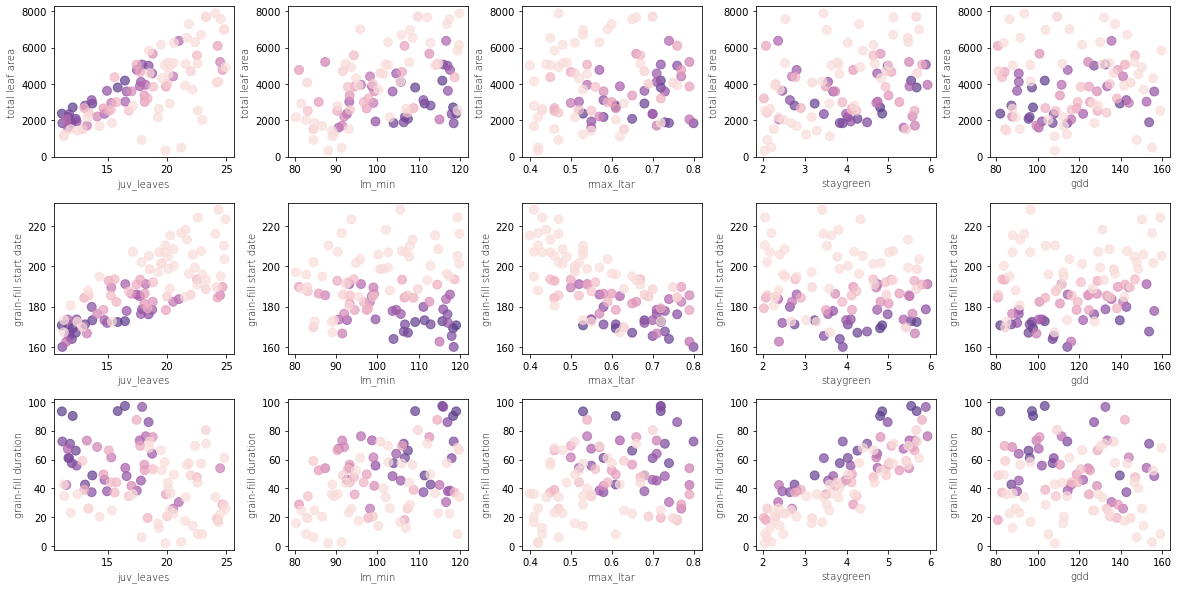

In [153]:
# set up iterables
params = ['juv_leaves', 'lm_min', 'rmax_ltar', 'staygreen', 'gdd']
emergent_properties = [LA, gf_startdates, gf_lengths]
properties_text = ['total leaf area', 'grain-fill start date', 'grain-fill duration']

# visualiztion
fig, axs = plt.subplots(len(emergent_properties), len(params), figsize=(20,10))
for count_x, param in enumerate(params):
    for count_y, emergent_property in enumerate(emergent_properties):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param], emergent_property, 
                   c=np.arange(100), cmap=PurpOr_6.mpl_colormap.reversed(), 
                   alpha=0.7, s=80, vmax=60)
        ax.set_xlabel(param, fontweight='light')
        ax.set_ylabel(properties_text[count_y], fontweight='light')

fig.subplots_adjust(wspace=0.3, hspace=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_emergent_properties.png', format='png', dpi=800)

In [24]:
yield_mean = df_all.groupby('cvar').mean().dm_ear
yield_variance = df_all.groupby('cvar').var().dm_ear
yield_disp = yield_variance/yield_mean

yield_mean_ranked = [yield_mean[pheno] for pheno in phenos_ranked]
yield_disp_ranked = [yield_disp[pheno] for pheno in phenos_ranked]

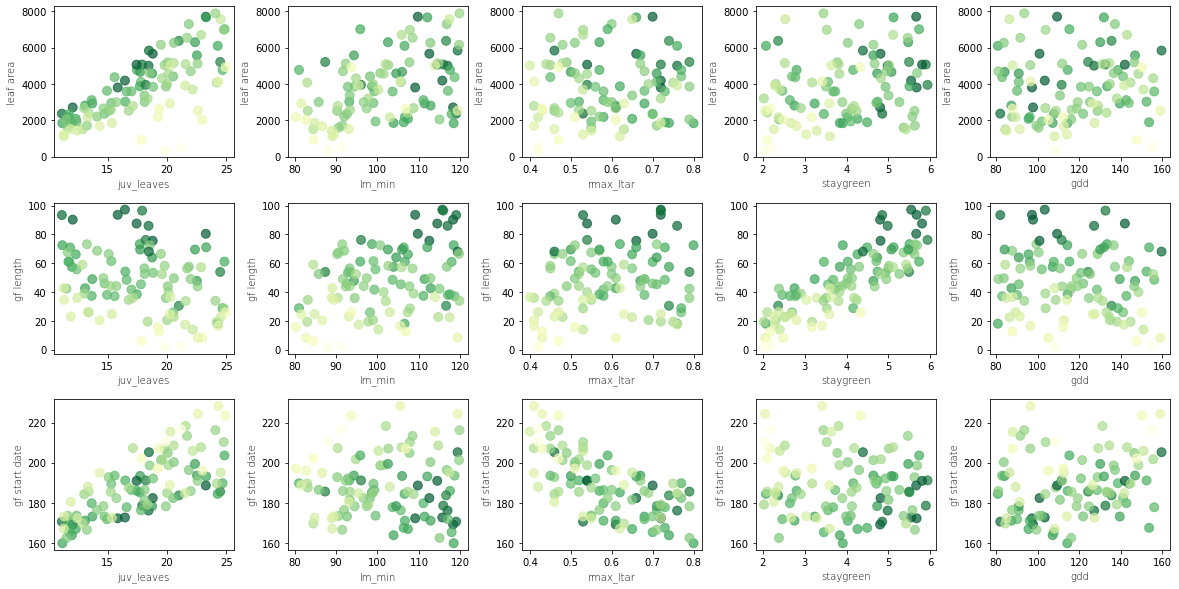

In [27]:
# set up iterables
params = ['juv_leaves', 'lm_min', 'rmax_ltar', 'staygreen', 'gdd']
emergent_properties = [LA, gf_lengths, gf_startdates]
properties_text = ['leaf area', 'gf length', 'gf start date']

# visualiztion
fig, axs = plt.subplots(len(emergent_properties), len(params), figsize=(20,10))
for count_x, param in enumerate(params):
    for count_y, emergent_property in enumerate(emergent_properties):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param], emergent_property, 
                   c=yield_mean_ranked, cmap=YlGn_8.mpl_colormap, 
                   alpha=0.7, s=80, vmax=200)
        ax.set_xlabel(param, fontweight='light')
        ax.set_ylabel(properties_text[count_y], fontweight='light')

fig.subplots_adjust(wspace=0.3, hspace=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_emergent_properties.png', format='png', dpi=800)

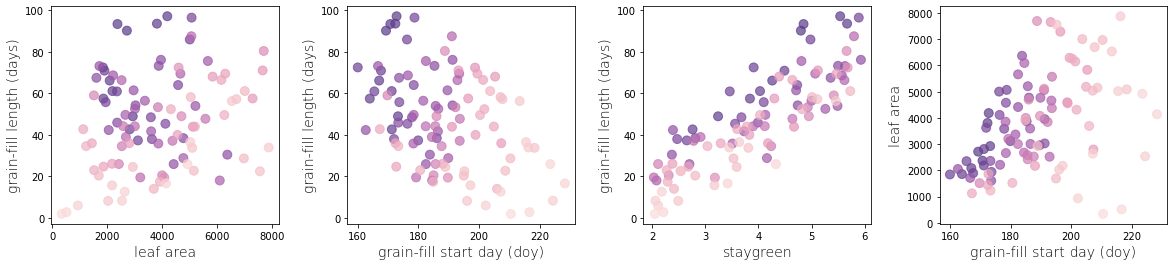

In [21]:
emergent_properties = [LA, gf_lengths, gf_startdates]
properties_text = ['leaf area', 'grain-fill length (days)', 'grain-fill start day (doy)']

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,4,1)
ax1.scatter(emergent_properties[0], emergent_properties[1], c=np.arange(100),
            cmap=PurpOr_6.mpl_colormap.reversed(), 
            alpha=0.7, s=80, vmax=100)
ax1.set_xlabel(properties_text[0], fontweight='light', size=14)
ax1.set_ylabel(properties_text[1], fontweight='light', size=14)

ax2 = fig.add_subplot(1,4,2)
ax2.scatter(emergent_properties[2], emergent_properties[1], c=np.arange(100),
            cmap=PurpOr_6.mpl_colormap.reversed(), 
            alpha=0.7, s=80, vmax=100)
ax2.set_xlabel(properties_text[2], fontweight='light', size=14)
ax2.set_ylabel(properties_text[1], fontweight='light', size=14)

ax3 = fig.add_subplot(1,4,3)
ax3.scatter(df_params_sub['staygreen'], gf_lengths,
            c=np.arange(100),
            cmap=PurpOr_6.mpl_colormap.reversed(), 
            alpha=0.7, s=80, vmax=100)
ax3.set_xlabel('staygreen', fontweight='light', size=14)
ax3.set_ylabel(properties_text[1], fontweight='light', size=14)

ax4 = fig.add_subplot(1,4,4)
ax4.scatter(emergent_properties[2], emergent_properties[0], c=np.arange(100),
            cmap=PurpOr_6.mpl_colormap.reversed(), 
            alpha=0.7, s=80, vmax=100)
ax4.set_xlabel(properties_text[2], fontweight='light', size=14)
ax4.set_ylabel(properties_text[0], fontweight='light', size=14)

fig.subplots_adjust(wspace=0.3, hspace=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_emergent_properties.png', format='png', dpi=800)

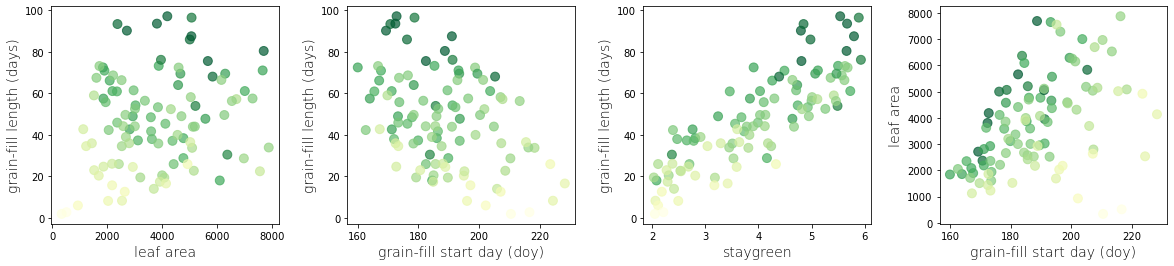

In [28]:
emergent_properties = [LA, gf_lengths, gf_startdates]
properties_text = ['leaf area', 'grain-fill length (days)', 'grain-fill start day (doy)']

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,4,1)
ax1.scatter(emergent_properties[0], emergent_properties[1],
            c=yield_mean_ranked, cmap=YlGn_8.mpl_colormap, 
            alpha=0.7, s=80, vmax=200)
ax1.set_xlabel(properties_text[0], fontweight='light', size=14)
ax1.set_ylabel(properties_text[1], fontweight='light', size=14)

ax2 = fig.add_subplot(1,4,2)
ax2.scatter(emergent_properties[2], emergent_properties[1], 
            c=yield_mean_ranked, cmap=YlGn_8.mpl_colormap, 
            alpha=0.7, s=80, vmax=200)
ax2.set_xlabel(properties_text[2], fontweight='light', size=14)
ax2.set_ylabel(properties_text[1], fontweight='light', size=14)

ax3 = fig.add_subplot(1,4,3)
ax3.scatter(df_params_sub['staygreen'], gf_lengths,
            c=yield_mean_ranked, cmap=YlGn_8.mpl_colormap, 
            alpha=0.7, s=80, vmax=200)
ax3.set_xlabel('staygreen', fontweight='light', size=14)
ax3.set_ylabel(properties_text[1], fontweight='light', size=14)

ax4 = fig.add_subplot(1,4,4)
ax4.scatter(emergent_properties[2], emergent_properties[0],
            c=yield_mean_ranked, cmap=YlGn_8.mpl_colormap, 
            alpha=0.7, s=80, vmax=200)
ax4.set_xlabel(properties_text[2], fontweight='light', size=14)
ax4.set_ylabel(properties_text[0], fontweight='light', size=14)

fig.subplots_adjust(wspace=0.3, hspace=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_emergent_properties.png', format='png', dpi=800)

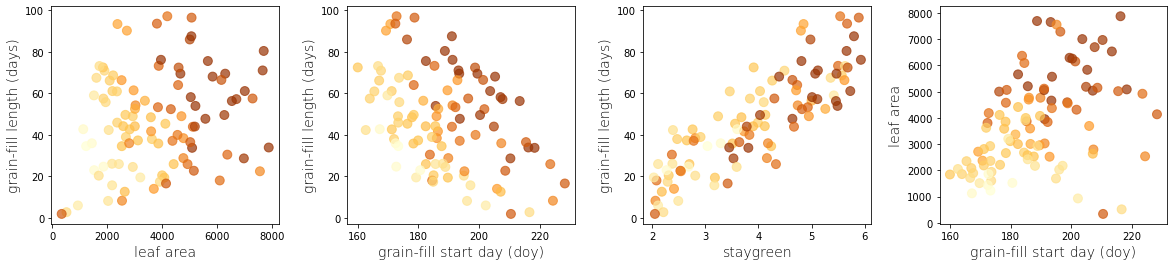

In [30]:
from palettable.colorbrewer.sequential import YlOrBr_6
from palettable.colorbrewer.sequential import YlGnBu_9

emergent_properties = [LA, gf_lengths, gf_startdates]
properties_text = ['leaf area', 'grain-fill length (days)', 'grain-fill start day (doy)']

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,4,1)
ax1.scatter(emergent_properties[0], emergent_properties[1],
            c=yield_disp_ranked, 
            cmap=YlOrBr_6.mpl_colormap, 
            alpha=0.7, s=80, vmax=12)
ax1.set_xlabel(properties_text[0], fontweight='light', size=14)
ax1.set_ylabel(properties_text[1], fontweight='light', size=14)

ax2 = fig.add_subplot(1,4,2)
ax2.scatter(emergent_properties[2], emergent_properties[1], 
            c=yield_disp_ranked, 
            cmap=YlOrBr_6.mpl_colormap, 
            alpha=0.7, s=80, vmax=12)
ax2.set_xlabel(properties_text[2], fontweight='light', size=14)
ax2.set_ylabel(properties_text[1], fontweight='light', size=14)

ax3 = fig.add_subplot(1,4,3)
ax3.scatter(df_params_sub['staygreen'], gf_lengths,
            c=yield_disp_ranked, 
            cmap=YlOrBr_6.mpl_colormap, 
            alpha=0.7, s=80, vmax=12)
ax3.set_xlabel('staygreen', fontweight='light', size=14)
ax3.set_ylabel(properties_text[1], fontweight='light', size=14)

ax4 = fig.add_subplot(1,4,4)
ax4.scatter(emergent_properties[2], emergent_properties[0],
            c=yield_disp_ranked, 
            cmap=YlOrBr_6.mpl_colormap, 
            alpha=0.7, s=80, vmax=12)
ax4.set_xlabel(properties_text[2], fontweight='light', size=14)
ax4.set_ylabel(properties_text[0], fontweight='light', size=14)

fig.subplots_adjust(wspace=0.3, hspace=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_emergent_properties.png', format='png', dpi=800)

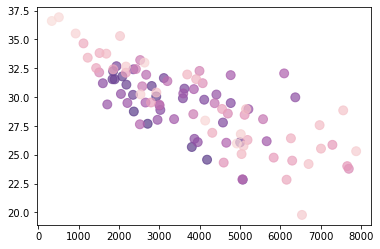

In [22]:
plt.scatter(LA, An_sun, c=np.arange(100),
            cmap=PurpOr_6.mpl_colormap.reversed(), 
            alpha=0.7, s=80)

## Emergent properties to yield

Disconnect between summarized phenotype versus all raw data from singel phenotype?
- We see a general trend between grain-fill length & yield when looking at overall summarized data from all phenotypes
- However, when you look closely at one singel phenotype, there's a much larger spread in specific phenotypes, maybe suggesting a non-linear relationship?
- Also, some phenotypes have really weird patterns, looks a bit like a bell-shaped curve, or is it just more like a cloud? I think it does peak at some point, but there's just also a lot of noise that makes it hard to pin point a pattern

- acorss phenotypes and averaged across all sites, the longer grain-filling, the higher the yield.
- However, within a single phenotype and across all sites, there is usually an optimum (unless you're like pheno 5 that your stay-green is so low that you don't really reach the topping point of having too-long of a grain-filling stage).
- It seems like it's mostly the phenotypes with really long stay-green parameters that you're seeing the leveling off of grain-filling length benefits on yield (it's mostly in northern sites I think, where temps are low and grain-fill gets dragged on).
- Even with that drop though, it seems like these phenotypes still generate much higher yield than other phenotypes such that it doesn't matter that they're not reaching their optimum they still out-compete others.

Text(0, 0.5, 'yield')

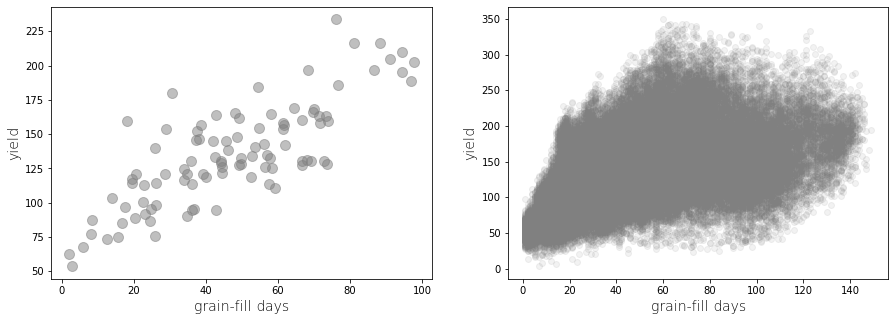

In [126]:
df_all.site = df_all.site.astype(int)
df_merged = df_pheno_gf.merge(df_all, on=['cvar','site','year'])

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_merged.groupby('cvar').mean().pheno_days,
            df_merged.groupby('cvar').mean().dm_ear, 
            s=100, color='grey', alpha=0.5)
ax1.set_xlabel('grain-fill days', fontweight='light', fontsize=14)
ax1.set_ylabel('yield', fontweight='light', fontsize=14)
# should try and label each with phenotype number
# maybe also add spread (error bars) across x & y?

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_merged.pheno_days, df_merged.dm_ear, 
            alpha=0.1, color='grey')
ax2.set_xlabel('grain-fill days', fontweight='light', fontsize=14)
ax2.set_ylabel('yield', fontweight='light', fontsize=14)
# maybe plot these in grey and mark high performers in light colors to see what region they fall in?
# make this into a heatmap or countour plot instead?

Text(0, 0.5, 'yield')

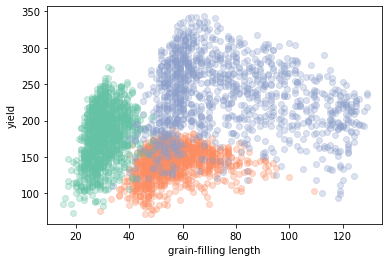

In [53]:
pheno = 76
plt.scatter(df_merged.query(f'cvar=={pheno}').pheno_days, 
            df_merged.query(f'cvar=={pheno}').dm_ear, 
            color='#fc8d62', alpha=0.3)

pheno = 5
plt.scatter(df_merged.query(f'cvar=={pheno}').pheno_days, 
            df_merged.query(f'cvar=={pheno}').dm_ear, 
            color='#66c2a5', alpha=0.3)

pheno = 9
plt.scatter(df_merged.query(f'cvar=={pheno}').pheno_days, 
            df_merged.query(f'cvar=={pheno}').dm_ear, 
            color='#8da0cb', alpha=0.3)

plt.xlabel('grain-filling length')
plt.ylabel('yield')

# *** note
# The wide spread in pheno_days length is probably due to site differences (cool vs. warm locations)
# Phenotypes with high stay-green values are the ones with really drawn out grain-filling lengths 
# (likely because the plants are having a hard time senescening under cooler northern climate).

Text(0, 0.5, 'grain-fill length')

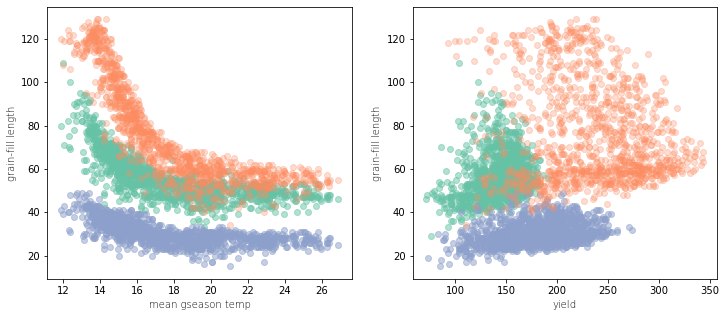

In [83]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
#pheno = 58
pheno=76
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').pheno_days, 
            color='#66c2a5', alpha=0.5)
#pheno = 89
pheno=5
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').pheno_days, 
            color='#8da0cb', alpha=0.5)
#pheno = 65
pheno=9
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').pheno_days, 
            color='#fc8d62', alpha=0.3)

ax1.set_xlabel('mean gseason temp', fontweight='light')
ax1.set_ylabel('grain-fill length', fontweight='light')


ax2 = fig.add_subplot(1,2,2)
#pheno = 58
pheno=76
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').pheno_days, 
            color='#66c2a5', alpha=0.5)
#pheno = 89
pheno=5
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').pheno_days, 
            color='#8da0cb', alpha=0.5)
#pheno = 65
pheno=9
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').pheno_days, 
            color='#fc8d62', alpha=0.3)

ax2.set_xlabel('yield', fontweight='light')
ax2.set_ylabel('grain-fill length', fontweight='light')

#### Non-linear relationship between grain-fill start date & yield
- Not very obvious when looking at all phenotypes at once, but becomes more prominent when only looking at one phenotype
- This seems to be the case, but how much of it is due to impacts on grain-filling length?
- Relationship between grain-fill start & grain-fill length also seems a bit odd. Non-linear with clear inflection point? No clear relationship between the two when transition is early, but with late transition time, see a positive relationship between transition time & grain-fill length -> the later you start, the longer your grain-fill period is
- Potential reasons: later start date means you have features that promote a long vegetative stage. These traits will likely also lead to longer longevity (buffered senescence), so in general it takes much longer for the plant to die down and reach maturity?

Text(0, 0.5, 'yield')

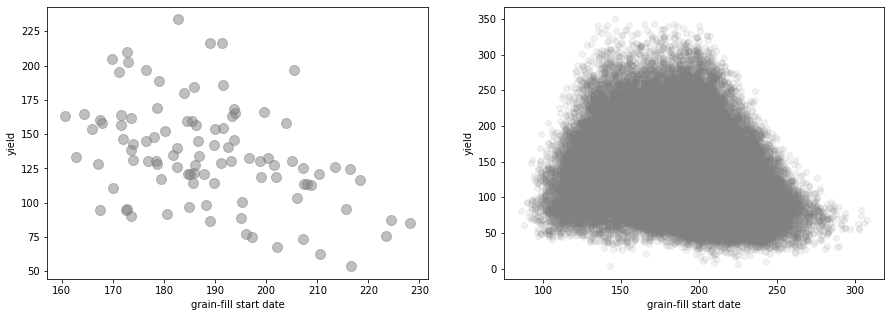

In [80]:
df_all.site = df_all.site.astype(int)
df_merged = df_pheno_gf.merge(df_all, on=['cvar','site','year'])

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_merged.groupby('cvar').mean().jday_x,
            df_merged.groupby('cvar').mean().dm_ear, 
            s=100, color='grey', alpha=0.5)
ax1.set_xlabel('grain-fill start date')
ax1.set_ylabel('yield')

# should try and label each with phenotype number
# maybe also add spread (error bars) across x & y?

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_merged.jday_x, df_merged.dm_ear, 
            alpha=0.1, color='grey')
ax2.set_xlabel('grain-fill start date')
ax2.set_ylabel('yield')
# maybe plot these in grey and mark high performers in light colors to see what region they fall in?
# make this into a heatmap or countour plot instead?

Text(0, 0.5, 'grain-fill start date')

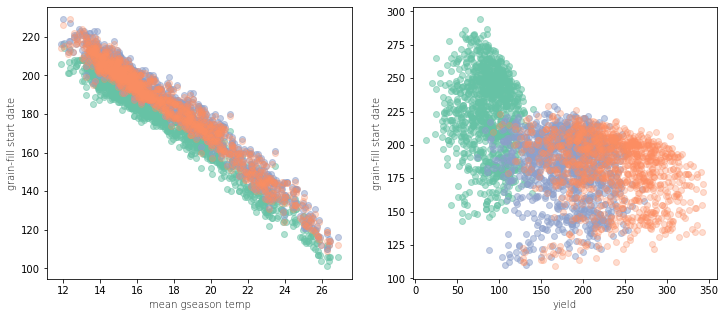

In [84]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
pheno = 76
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#66c2a5', alpha=0.5)
pheno = 5
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#8da0cb', alpha=0.5)
pheno = 9
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#fc8d62', alpha=0.3)

ax1.set_xlabel('mean gseason temp', fontweight='light')
ax1.set_ylabel('grain-fill start date', fontweight='light')


ax2 = fig.add_subplot(1,2,2)
pheno = 67
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#66c2a5', alpha=0.5)
pheno = 5
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#8da0cb', alpha=0.5)
pheno = 9
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#fc8d62', alpha=0.3)

ax2.set_xlabel('yield', fontweight='light')
ax2.set_ylabel('grain-fill start date', fontweight='light')

Text(0, 0.5, 'grain-fill start date')

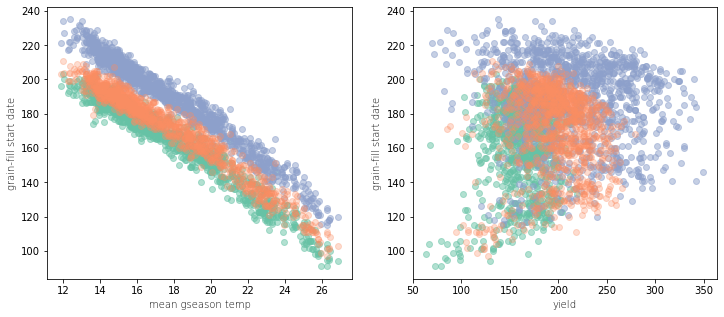

In [76]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
pheno = 58
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#66c2a5', alpha=0.5)
pheno = 89
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#8da0cb', alpha=0.5)
pheno = 65
ax1.scatter(df_merged.query(f'cvar=={pheno}').temp, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#fc8d62', alpha=0.3)

ax1.set_xlabel('mean gseason temp', fontweight='light')
ax1.set_ylabel('grain-fill start date', fontweight='light')


ax2 = fig.add_subplot(1,2,2)
pheno = 58
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#66c2a5', alpha=0.5)
pheno = 89
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#8da0cb', alpha=0.5)
pheno = 65
ax2.scatter(df_merged.query(f'cvar=={pheno}').dm_ear, 
            df_merged.query(f'cvar=={pheno}').jday_x, 
            color='#fc8d62', alpha=0.3)

ax2.set_xlabel('yield', fontweight='light')
ax2.set_ylabel('grain-fill start date', fontweight='light')

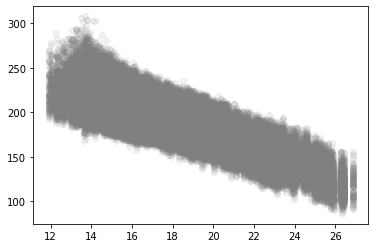

In [77]:
plt.scatter(df_merged.temp, df_merged.jday_x, 
            alpha=0.1, color='grey')

In [188]:
df_sub = df_phys[df_phys.pheno=='"Tasselinit"'].query('cvar==5')
#df_wea.site = df_wea.site.astype(int)
df_merged = df_sub.merge(df_wea, on=['site','year'])
df_merged.columns

Index(['cvar', 'site', 'year', 'pheno', 'gs', 'pn', 'pg', 'LAI_sun',
       'LAI_shade', 'Ag_sun', 'Ag_shade', 'An_sun', 'An_shade', 'sun_perct',
       'shade_perct', 'Ag', 'An', 'temp', 'temp_var', 'rh', 'rh_var', 'vpd',
       'precip', 'precip_var', 'solrad', 'solrad_var'],
      dtype='object')

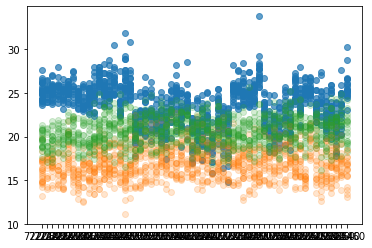

In [285]:
df_climate_sub = df_gseason_climate[df_gseason_climate.pheno == '"grainFill"'].query('cvar==5')
df_climate_sub.site = df_climate_sub.site.astype(str)
plt.scatter(df_climate_sub.site, df_climate_sub.temp_air, alpha=0.7)

df_climate_sub = df_gseason_climate[df_gseason_climate.pheno == '"Emerged"'].query('cvar==5')
df_climate_sub.site = df_climate_sub.site.astype(str)
plt.scatter(df_climate_sub.site, df_climate_sub.temp_air, alpha=0.2)

df_climate_sub = df_gseason_climate[df_gseason_climate.pheno == '"Tasselinit"'].query('cvar==5')
df_climate_sub.site = df_climate_sub.site.astype(str)
plt.scatter(df_climate_sub.site, df_climate_sub.temp_air, alpha=0.2)

Text(0.5, 0.98, '"grainFill"')

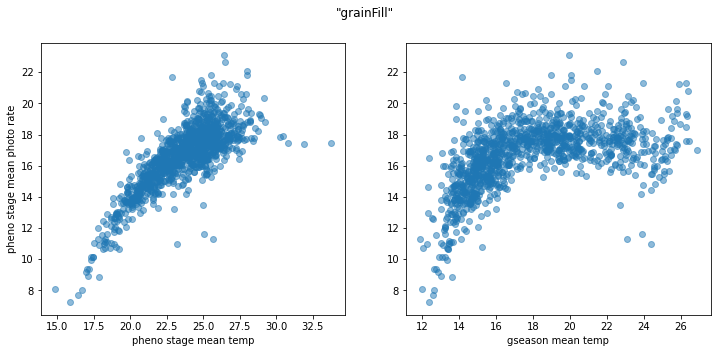

In [305]:
# but when you actually plot it against the climate of that specific pheno stage
# you see a clear positive relationship
# seems like photosynthesis never reaches its temperature optimum,
# other than towards the very end of the season (grain-fill)
# and even then it barely seems to plateau.

cvar = 5
#pheno_stage = '"Emerged"'
#pheno_stage = '"Tasselinit"'
#pheno_stage = '"Tasseled"'
#pheno_stage = '"Silked"'
pheno_stage = '"grainFill"'


df_climate_sub = df_gseason_climate[df_gseason_climate.pheno == f'{pheno_stage}'].query(f'cvar=={cvar}')
df_phys_sub = df_phys[df_phys.pheno==f'{pheno_stage}'].query(f'cvar=={cvar}')
df_merged_gseason = df_phys_sub.merge(df_wea, on=['site','year'])

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_climate_sub.temp_air, df_phys_sub.An, alpha=0.5)
ax1.set_xlabel('pheno stage mean temp')
ax1.set_ylabel('pheno stage mean photo rate')

# correlating photosynthesis of specific pheno stage with 
# average gseason climate condition shows little correlation
ax2= fig.add_subplot(1,2,2)
ax2.scatter(df_merged_gseason.temp, df_merged_gseason.An, alpha=0.5)
ax2.set_xlabel('gseason mean temp')
fig.suptitle(f'{pheno_stage}')

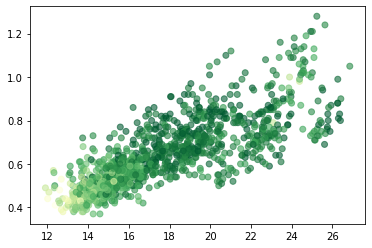

In [181]:
plt.scatter(df_merged.temp, df_merged.vpd, c=df_merged.An,
            cmap=YlGn_8.mpl_colormap, alpha=0.6, vmax=19)

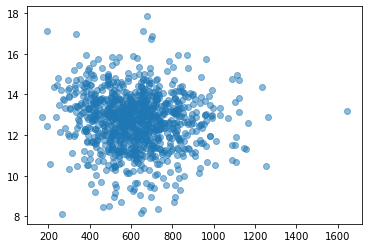

In [168]:
plt.scatter(df_merged.query('temp<22').precip, df_merged.query('temp<22').An, alpha=0.5)

In [94]:
df_all.shape

(112623, 83)

In [96]:
df_wea.head()

site  year   temp  temp_var     rh    rh_var   vpd  precip  precip_var  \
0  724290  1964  17.47  4.184320  65.71  4.857886  0.69   577.9    0.000989   
1  726400  1982  13.22  6.282663  69.12  4.510377  0.47   546.1    0.001160   
2  722340  1961  21.10  2.087655  77.59  5.466569  0.57   845.2    0.001669   
3  724380  1964  17.67  4.173954  68.14  4.588453  0.65   651.4    0.001293   
4  722230  1998  23.48  1.906903  79.40  4.269087  0.61  1388.8    0.003125   

   solrad  solrad_var  
0  220.09  366.640684  
1  205.62  344.164206  
2  226.20  378.008650  
3  217.30  360.636559  
4  237.08  403.697971